In [141]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision import models
import string
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from torch.utils.data import DataLoader
from tqdm import tqdm
!pip install adabelief-pytorch==0.2.0
from adabelief_pytorch import AdaBelief
from torch.optim import *
import math
from sklearn.metrics import f1_score

In [31]:
! /opt/bin/nvidia-smi

Thu Apr 15 11:18:12 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P0    37W / 250W |   4553MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [32]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
torch.cuda.memory_summary(device=None, abbreviated=False)
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Resize(224),
     transforms.Normalize((0.5), (0.5))])

train_set = torchvision.datasets.EMNIST(root='./data', train=True, download=True, transform=transform, split='bymerge')
test_set = torchvision.datasets.EMNIST(root='./data', train=False, download=False, transform=transform, split='bymerge')



cuda:0


In [33]:
cfg = {
    'VGG_ba_small': [16, 'M', 32, 'M', 64, 'M', 128, 'M', 128, 'M'],
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}


class VGG(nn.Module):
    def __init__(self, vgg_name):
        super(VGG, self).__init__()
        self.features = self._make_layers(cfg[vgg_name])
        self.classifier = nn.Linear(128 * 7 * 7, 47)

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = F.dropout(out, p=0.5, training=self.training)
        out = self.classifier(out)
        return out

    def _make_layers(self, cfg):
        layers = []
        in_channels = 1
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]
                in_channels = x
        layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)

In [34]:
def evaluate(model, valid_dl):

  # we don't want to add evaluation related computation to computation graph
  with torch.no_grad():
    criterion = nn.CrossEntropyLoss()
    valid_loss_lst = torch.tensor([]).to('cuda')
    y_true_lst = torch.tensor([]).to('cuda')
    y_pred_lst = torch.tensor([]).to('cuda')
    
    for X_valid, y_valid in valid_dl:
      X_valid = X_valid.to('cuda')
      y_valid = y_valid.to('cuda')
      pred = model(X_valid)
      valid_loss_lst = torch.cat((valid_loss_lst, criterion(pred, y_valid).view(-1)))
      predicted = pred.argmax(1).squeeze()
      y_pred_lst = torch.cat((y_pred_lst, predicted))
      y_true_lst = torch.cat((y_true_lst, y_valid))

  return valid_loss_lst.mean().item(), f1_score(y_pred=y_pred_lst.to('cpu'), y_true=y_true_lst.to('cpu'), average='micro')

def train(**params):

  # define model and move it to gpu  
  model = params['model']
  model.to('cuda')

  # define optimizer
  opt = params['optimizer'][0](model.parameters(), **params['optimizer'][1])

  # define data loader
  
  train_dl = DataLoader(params['train_data'], batch_size=params['batch_size'])
  valid_dl = DataLoader(params['test_data'], batch_size=params['batch_size'])

  # define loss
  criterion = torch.nn.CrossEntropyLoss()

  # start training
  valid_loss_lst = []
  train_loss_lst = []
  train_f1_lst = []
  valid_f1_lst = []

  for e in tqdm(range(params['epochs'])):
    train_losses = torch.tensor([]).to('cuda')
    correct = 0
    y_true_lst = torch.tensor([]).to('cuda')
    y_pred_lst = torch.tensor([]).to('cuda')
    
    for X_train, y_train in train_dl:

      X_train = X_train.to('cuda')
      y_train = y_train.to('cuda')
        
      pred = model(X_train)
      loss = criterion(pred, y_train)

      # perform backward propagation
      loss.backward()

      # update model parameters and clear up gradient after update
      opt.step()
      opt.zero_grad()
      train_losses = torch.cat((train_losses, loss.view(-1)))

      with torch.no_grad():
        predicted = pred.argmax(1).squeeze()
        y_pred_lst = torch.cat((y_pred_lst, predicted))
        y_true_lst = torch.cat((y_true_lst, y_train))
      
        
    valid_loss, valid_f1 = evaluate(model, valid_dl)
    train_loss = train_losses.mean().item()
    train_f1 = f1_score(y_pred=y_pred_lst.to('cpu'), y_true=y_true_lst.to('cpu'), average='micro')
    train_loss_lst.append(train_loss)
    valid_loss_lst.append(valid_loss)
    train_f1_lst.append(train_f1)
    valid_f1_lst.append(valid_f1)
    

    print(f'epoch: {e}, training loss: {train_loss}, training f1: {train_f1}, validation loss: {valid_loss}, validation f1: {valid_f1}')

  return model, train_loss_lst, valid_loss_lst, train_f1_lst, valid_f1_lst

In [35]:
my_vgg_SGD = VGG('VGG_ba_small')
params = {
    'optimizer': (torch.optim.SGD, {'lr': 0.0005, 'momentum': 0.9}),
    'model': my_vgg_SGD,
    'epochs': 10,
    'batch_size': 64,
    'train_data': train_set,
    'test_data': test_set
    
}

model_SGD, train_loss_lst_SGD, valid_loss_lst_SGD, train_f1_lst_SGD, valid_f1_lst_SGD = train(**params)




  0%|          | 0/10 [00:00<?, ?it/s]


 10%|█         | 1/10 [18:52<2:49:53, 1132.65s/it]

epoch: 0, training loss: 0.4686826169490814, training f1: 0.8460680983247651, validation loss: 0.3687134385108948, validation f1: 0.8716848774532981





 20%|██        | 2/10 [37:46<2:31:03, 1132.98s/it]

epoch: 1, training loss: 0.34945404529571533, training f1: 0.8776571356521838, validation loss: 0.339288592338562, validation f1: 0.8799549530187495





 30%|███       | 3/10 [56:33<2:11:58, 1131.20s/it]

epoch: 2, training loss: 0.3255620300769806, training f1: 0.8845489245370609, validation loss: 0.324160635471344, validation f1: 0.884923875759738





 40%|████      | 4/10 [1:15:09<1:52:39, 1126.56s/it]

epoch: 3, training loss: 0.31173017621040344, training f1: 0.8884046010213029, validation loss: 0.31169915199279785, validation f1: 0.8883023993535243





 50%|█████     | 5/10 [1:33:33<1:33:19, 1119.95s/it]

epoch: 4, training loss: 0.3014194667339325, training f1: 0.8915968890952127, validation loss: 0.30904799699783325, validation f1: 0.8889385590124051





 60%|██████    | 6/10 [1:51:42<1:14:02, 1110.65s/it]

epoch: 5, training loss: 0.29448992013931274, training f1: 0.8933778648922818, validation loss: 0.3012005686759949, validation f1: 0.8927813072221313





 70%|███████   | 7/10 [2:09:50<55:11, 1103.76s/it]  

epoch: 6, training loss: 0.2882595658302307, training f1: 0.8950771708418586, validation loss: 0.29704833030700684, validation f1: 0.892910258504337





 80%|████████  | 8/10 [2:28:30<36:57, 1108.57s/it]

epoch: 7, training loss: 0.2831100821495056, training f1: 0.8967965360522229, validation loss: 0.29497283697128296, validation f1: 0.8940278362834521





 90%|█████████ | 9/10 [2:47:09<18:31, 1111.70s/it]

epoch: 8, training loss: 0.27864325046539307, training f1: 0.8983210398720792, validation loss: 0.29125815629959106, validation f1: 0.895093833549685





100%|██████████| 10/10 [3:05:41<00:00, 1114.19s/it]

epoch: 9, training loss: 0.2754361033439636, training f1: 0.8990317108256964, validation loss: 0.28914812207221985, validation f1: 0.8938902882490994


In [37]:
import pandas as pd
sgd_df = pd.DataFrame(data={'train_loss': train_loss_lst_SGD, 
                            'valid_loss': valid_loss_lst_SGD, 
                            'train_f1': train_f1_lst_SGD, 
                            'valid_f1': valid_f1_lst_SGD, 
                            'category': ['sgd']*len(train_loss_lst_SGD)})

sgd_df.to_parquet('./sgd_results.parquet')

In [38]:
my_vgg_Adam = VGG('VGG_ba_small')
params = {
    'optimizer': (torch.optim.Adam, {'lr': 0.0005}),
    'model': my_vgg_Adam,
    'epochs': 10,
    'batch_size': 64,
    'train_data': train_set,
    'test_data': test_set
}
model_Adam, train_loss_lst_Adam, valid_loss_lst_Adam, train_f1_lst_Adam, valid_f1_lst_Adam = train(**params)




  0%|          | 0/10 [00:00<?, ?it/s]


 10%|█         | 1/10 [18:23<2:45:27, 1103.05s/it]

epoch: 0, training loss: 0.40532299876213074, training f1: 0.8625482138661072, validation loss: 0.3221723735332489, validation f1: 0.8854396808885604





 20%|██        | 2/10 [36:47<2:27:08, 1103.56s/it]

epoch: 1, training loss: 0.30215516686439514, training f1: 0.8916069187256065, validation loss: 0.2968893051147461, validation f1: 0.8925062111534262





 30%|███       | 3/10 [54:54<2:08:10, 1098.60s/it]

epoch: 2, training loss: 0.27969852089881897, training f1: 0.8983525615676026, validation loss: 0.284818172454834, validation f1: 0.8970710865435039





 40%|████      | 4/10 [1:13:13<1:49:52, 1098.76s/it]

epoch: 3, training loss: 0.26750752329826355, training f1: 0.9016623395975539, validation loss: 0.2814164459705353, validation f1: 0.8980511162882663





 50%|█████     | 5/10 [1:31:30<1:31:30, 1098.12s/it]

epoch: 4, training loss: 0.259922593832016, training f1: 0.9038072476974834, validation loss: 0.2789804935455322, validation f1: 0.8983863896220008





 60%|██████    | 6/10 [1:50:03<1:13:30, 1102.68s/it]

epoch: 5, training loss: 0.253997266292572, training f1: 0.9055079864514022, validation loss: 0.2739771008491516, validation f1: 0.899968192017056





 70%|███████   | 7/10 [2:08:31<55:12, 1104.09s/it]  

epoch: 6, training loss: 0.24872644245624542, training f1: 0.906963715662844, validation loss: 0.27318844199180603, validation f1: 0.9010427860354359





 80%|████████  | 8/10 [2:27:13<36:59, 1109.60s/it]

epoch: 7, training loss: 0.2446349412202835, training f1: 0.9082403443315394, validation loss: 0.26984769105911255, validation f1: 0.9020228157801984





 90%|█████████ | 9/10 [2:46:00<18:34, 1114.68s/it]

epoch: 8, training loss: 0.24118079245090485, training f1: 0.9091344142409289, validation loss: 0.2735593914985657, validation f1: 0.9010255925311418





100%|██████████| 10/10 [3:04:57<00:00, 1109.80s/it]

epoch: 9, training loss: 0.23823978006839752, training f1: 0.9104382661921219, validation loss: 0.27121448516845703, validation f1: 0.902177557318845


In [41]:
adam_df =  pd.DataFrame(data={'train_loss': train_loss_lst_Adam, 
                            'valid_loss': valid_loss_lst_Adam, 
                            'train_f1': train_f1_lst_Adam, 
                            'valid_f1': valid_f1_lst_Adam, 
                            'category': ['adam']*len(train_loss_lst_Adam)})

adam_df.to_parquet('./adam_results.parquet')

In [44]:
my_vgg_AdaBelief = VGG('VGG_ba_small')
params = {
    'optimizer': (AdaBelief, {'lr': 0.0005}),
    'model': my_vgg_AdaBelief,
    'epochs': 10,
    'batch_size': 64,
    'train_data': train_set,
    'test_data': test_set
}
model_AdaBelief, train_loss_lst_AdaBelief, valid_loss_lst_AdaBelief, train_f1_lst_AdaBelief, valid_f1_lst_AdaBelief = train(**params)




  0%|          | 0/10 [00:00<?, ?it/s]

Please check your arguments if you have upgraded adabelief-pytorch from version 0.0.5.
Modifications to default arguments:
                           eps  weight_decouple    rectify
-----------------------  -----  -----------------  ---------
adabelief-pytorch=0.0.5  1e-08  False              False
>=0.1.0 (Current 0.2.0)  1e-16  True               True
SGD better than Adam (e.g. CNN for Image Classification)    Adam better than SGD (e.g. Transformer, GAN)
----------------------------------------------------------  ----------------------------------------------
Recommended eps = 1e-8                                      Recommended eps = 1e-16
For a complete table of recommended hyperparameters, see
https://github.com/juntang-zhuang/Adabelief-Optimizer
You can disable the log message by setting "print_change_log = False", though it is recommended to keep as a reminder.

Weight decoupling enabled in AdaBelief
Rectification enabled in AdaBelief





 10%|█         | 1/10 [19:05<2:51:50, 1145.60s/it]

epoch: 0, training loss: 0.43632328510284424, training f1: 0.8548110704194678, validation loss: 0.3271429240703583, validation f1: 0.884494038152386





 20%|██        | 2/10 [38:01<2:32:21, 1142.73s/it]

epoch: 1, training loss: 0.30618026852607727, training f1: 0.8905108234039992, validation loss: 0.29636576771736145, validation f1: 0.8932627253423656





 30%|███       | 3/10 [56:44<2:12:36, 1136.71s/it]

epoch: 2, training loss: 0.2825118899345398, training f1: 0.8973639265716431, validation loss: 0.2863066494464874, validation f1: 0.8965896684232697





 40%|████      | 4/10 [1:15:28<1:53:18, 1133.04s/it]

epoch: 3, training loss: 0.26912814378738403, training f1: 0.901226767077595, validation loss: 0.2813362777233124, validation f1: 0.8990741297937639





 50%|█████     | 5/10 [1:34:23<1:34:27, 1133.51s/it]

epoch: 4, training loss: 0.26102182269096375, training f1: 0.9034963291552759, validation loss: 0.27803149819374084, validation f1: 0.8989537752637053





 60%|██████    | 6/10 [1:53:20<1:15:38, 1134.56s/it]

epoch: 5, training loss: 0.2543157637119293, training f1: 0.9054621367124591, validation loss: 0.2737492322921753, validation f1: 0.9004152231287019





 70%|███████   | 7/10 [2:12:14<56:43, 1134.53s/it]  

epoch: 6, training loss: 0.2493111789226532, training f1: 0.9069321939673206, validation loss: 0.272390216588974, validation f1: 0.9011373503090533





 80%|████████  | 8/10 [2:31:22<37:56, 1138.42s/it]

epoch: 7, training loss: 0.245146244764328, training f1: 0.9077861453551349, validation loss: 0.27176058292388916, validation f1: 0.902409669626815





 90%|█████████ | 9/10 [2:50:31<19:01, 1141.66s/it]

epoch: 8, training loss: 0.2414223849773407, training f1: 0.9091086237627735, validation loss: 0.2738792300224304, validation f1: 0.9010169957789947





100%|██████████| 10/10 [3:09:25<00:00, 1136.55s/it]

epoch: 9, training loss: 0.23889192938804626, training f1: 0.9099138598029608, validation loss: 0.2726854979991913, validation f1: 0.9006645289409662


In [46]:

belif_df = pd.DataFrame(data={'train_loss': train_loss_lst_AdaBelief, 
                            'valid_loss': valid_loss_lst_AdaBelief, 
                            'train_f1': train_f1_lst_AdaBelief, 
                            'valid_f1': valid_f1_lst_AdaBelief, 
                            'category': ['belief']*len(train_loss_lst_AdaBelief)})

belif_df.to_parquet('./belif_results.parquet')

In [47]:
class Padam(Optimizer):
    """Implements Partially adaptive momentum estimation (Padam) algorithm.
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float, optional): learning rate (default: 1e-1)
        betas (Tuple[float, float], optional): coefficients used for computing
            running averages of gradient and its square (default: (0.9, 0.999))
        eps (float, optional): term added to the denominator to improve
            numerical stability (default: 1e-8)
        weight_decay (float, optional): weight decay (L2 penalty) (default: 0)
        partial (float, optional): partially adaptive parameter
    """

    def __init__(self, params, lr=1e-1, betas=(0.9, 0.999), eps=1e-8, weight_decay=0, amsgrad=True, partial = 1/4):
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay, amsgrad=amsgrad, partial = partial)
        super(Padam, self).__init__(params, defaults)

    def step(self, closure=None):
        """Performs a single optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError('Adam does not support sparse gradients, please consider SparseAdam instead')
                amsgrad = group['amsgrad']
                partial = group['partial']

                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    # Exponential moving average of gradient values
                    state['exp_avg'] = torch.zeros_like(p.data)
                    # Exponential moving average of squared gradient values
                    state['exp_avg_sq'] = torch.zeros_like(p.data)
                    if amsgrad:
                        # Maintains max of all exp. moving avg. of sq. grad. values
                        state['max_exp_avg_sq'] = torch.zeros_like(p.data)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                if amsgrad:
                    max_exp_avg_sq = state['max_exp_avg_sq']
                beta1, beta2 = group['betas']

                state['step'] += 1

                if group['weight_decay'] != 0:
                    grad = grad.add(group['weight_decay'], p.data)

                # Decay the first and second moment running average coefficient
                exp_avg.mul_(beta1).add_(1 - beta1, grad)
                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                if amsgrad:
                    # Maintains the maximum of all 2nd moment running avg. till now
                    torch.max(max_exp_avg_sq, exp_avg_sq, out=max_exp_avg_sq)
                    # Use the max. for normalizing running avg. of gradient
                    denom = max_exp_avg_sq.sqrt().add_(group['eps'])
                else:
                    denom = exp_avg_sq.sqrt().add_(group['eps'])

                bias_correction1 = 1 - beta1 ** state['step']
                bias_correction2 = 1 - beta2 ** state['step']
                step_size = group['lr'] * math.sqrt(bias_correction2) / bias_correction1

                p.data.addcdiv_(-step_size, exp_avg, denom**(partial*2))
                
        return loss


In [49]:
my_vgg_Padam = VGG('VGG_ba_small')
params = {
    'optimizer': (Padam, {'lr': 0.0005}),
    'model': my_vgg_Padam,
    'epochs': 10,
    'batch_size': 64,
    'train_data': train_set,
    'test_data': test_set
}
model_Padam, train_loss_lst_Padam, valid_loss_lst_Padam, train_f1_lst_Padam, valid_f1_lst_Padam = train(**params)




  0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:1005.)



 10%|█         | 1/10 [18:55<2:50:18, 1135.34s/it]

epoch: 0, training loss: 0.4945899546146393, training f1: 0.8410188958236618, validation loss: 0.36377882957458496, validation f1: 0.8746249666875854





 20%|██        | 2/10 [37:42<2:31:02, 1132.80s/it]

epoch: 1, training loss: 0.3400209844112396, training f1: 0.8807176057266324, validation loss: 0.3347501754760742, validation f1: 0.8823534468677733





 30%|███       | 3/10 [56:35<2:12:09, 1132.84s/it]

epoch: 2, training loss: 0.3177006244659424, training f1: 0.8874661141773124, validation loss: 0.31683042645454407, validation f1: 0.8872364020872915





 40%|████      | 4/10 [1:15:47<1:53:52, 1138.68s/it]

epoch: 3, training loss: 0.30482596158981323, training f1: 0.8907672953812119, validation loss: 0.3090566396713257, validation f1: 0.8898068309792561





 50%|█████     | 5/10 [1:34:59<1:35:13, 1142.78s/it]

epoch: 4, training loss: 0.2954528033733368, training f1: 0.8938951072597331, validation loss: 0.3011719286441803, validation f1: 0.8924202436319558





 60%|██████    | 6/10 [1:53:46<1:15:52, 1138.07s/it]

epoch: 5, training loss: 0.288004994392395, training f1: 0.8956746502524602, validation loss: 0.2978178560733795, validation f1: 0.8934088701288653





 70%|███████   | 7/10 [2:12:46<56:55, 1138.44s/it]  

epoch: 6, training loss: 0.282694548368454, training f1: 0.8972321085721818, validation loss: 0.2942315638065338, validation f1: 0.892910258504337





 80%|████████  | 8/10 [2:32:09<38:11, 1145.94s/it]

epoch: 7, training loss: 0.2785903513431549, training f1: 0.898571780631924, validation loss: 0.29116320610046387, validation f1: 0.8941567875656576





 90%|█████████ | 9/10 [2:50:43<18:56, 1136.28s/it]

epoch: 8, training loss: 0.2743731737136841, training f1: 0.8993483605852719, validation loss: 0.2879578769207001, validation f1: 0.8957901704735951





100%|██████████| 10/10 [3:09:10<00:00, 1135.04s/it]

epoch: 9, training loss: 0.2710990309715271, training f1: 0.9003656516680708, validation loss: 0.28388693928718567, validation f1: 0.896847570987681


In [51]:

padam_df = pd.DataFrame(data={'train_loss': train_loss_lst_Padam, 
                            'valid_loss': valid_loss_lst_Padam, 
                            'train_f1': train_f1_lst_Padam, 
                            'valid_f1': valid_f1_lst_Padam, 
                            'category': ['padam']*len(train_loss_lst_Padam)})

padam_df.to_parquet('./padam_results.parquet')

In [57]:
full_df = pd.concat([belif_df, adam_df, padam_df, sgd_df])
full_df.to_parquet('./full_df30.parquet')

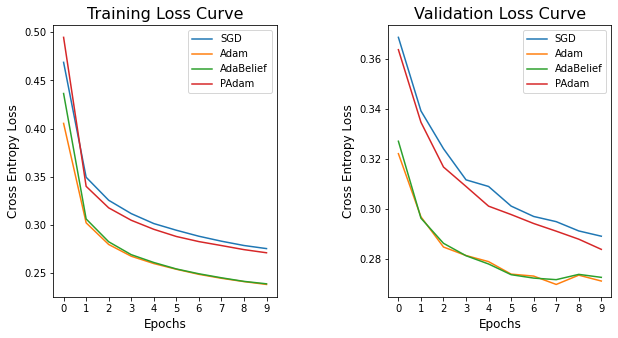

In [140]:
from matplotlib.pyplot import MultipleLocator
epo=[i for i in range(10)]
plt.figure(figsize=(10, 5))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None,
                wspace=0.5, hspace=0.5)
plt.subplot(121)
plt.title("Training Loss Curve", fontsize=16)
plt.plot(epo, sgd_df['train_loss'], label="SGD")
plt.plot(epo, adam_df['train_loss'], label="Adam")
plt.plot(epo, belif_df['train_loss'], label="AdaBelief")
plt.plot(epo, padam_df['train_loss'], label="PAdam")

x_major_locator=MultipleLocator(1)
ax=plt.gca()
ax.xaxis.set_major_locator(x_major_locator)
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Cross Entropy Loss", fontsize=12)
plt.legend()


plt.subplot(122)

plt.title("Validation Loss Curve", fontsize=16)
plt.plot(epo, sgd_df['valid_loss'], label="SGD")
plt.plot(epo, adam_df['valid_loss'], label="Adam")
plt.plot(epo, belif_df['valid_loss'], label="AdaBelief")
plt.plot(epo, padam_df['valid_loss'], label="PAdam")
x_major_locator=MultipleLocator(1)
ax=plt.gca()
ax.xaxis.set_major_locator(x_major_locator)
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Cross Entropy Loss", fontsize=12)
plt.legend()
plt.savefig('./vgg_loss.png')
plt.show()

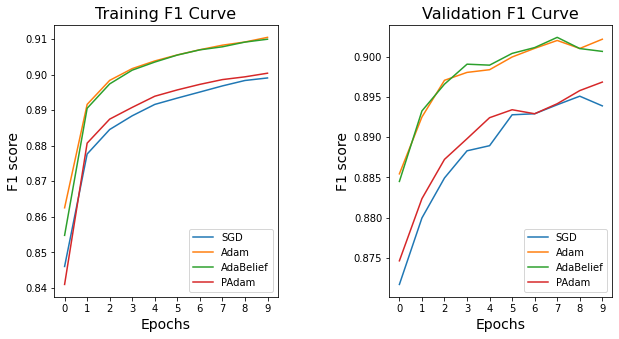

In [139]:
from matplotlib.pyplot import MultipleLocator
epo=[i for i in range(10)]
plt.figure(figsize=(10, 5))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None,
                wspace=0.5, hspace=0.5)
plt.subplot(121)
plt.title("Training F1 Curve", fontsize=16)
plt.plot(epo, sgd_df['train_f1'], label="SGD")
plt.plot(epo, adam_df['train_f1'], label="Adam")
plt.plot(epo, belif_df['train_f1'], label="AdaBelief")
plt.plot(epo, padam_df['train_f1'], label="PAdam")

x_major_locator=MultipleLocator(1)
ax=plt.gca()
ax.xaxis.set_major_locator(x_major_locator)
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("F1 score", fontsize=14)
plt.legend()


plt.subplot(122)

plt.title("Validation F1 Curve", fontsize=16)
plt.plot(epo, sgd_df['valid_f1'], label="SGD")
plt.plot(epo, adam_df['valid_f1'], label="Adam")
plt.plot(epo, belif_df['valid_f1'], label="AdaBelief")
plt.plot(epo, padam_df['valid_f1'], label="PAdam")
x_major_locator=MultipleLocator(1)
ax=plt.gca()
ax.xaxis.set_major_locator(x_major_locator)

plt.xlabel("Epochs", fontsize=14)
plt.ylabel("F1 score", fontsize=14)
plt.legend()
plt.savefig('vgg_f1.png')
plt.show()


In [160]:
!pip install torchviz
from torchviz import make_dot
my_model = VGG('VGG_ba_small')
out = my_model(torch.randn(64,1,224,224))
make_dot(out, dict(my_model.named_parameters())).render('model', format='png')

'model.png'